In this notebook we introduce additional model performance metrics that
can be used for non-standard cases: Cohen's kappa,
calibration plots, Brier score, normalized discounted cumulative gain
(NDCG).

# Cohen's kappa (classification)

Cohen’s Kappa (κ) is a statistical measure of inter-rater agreement for categorical data, correcting for agreement occurring by chance. Classes are mutually esclusive and not ordered. Think about classifying fruits (apples, oranges, ...)

Cohen’s Kappa can be used to measure the agreement between the true and the predicted classification, but it can also be used to evaluate how coherent (or different) two classificators are.

The formula for Cohen’s Kappa is:

```
    P0 - Pe
κ = -------
     1 - Pe
```

where:

* P0 = observed agreement (the proportion of times the raters agree)
* Pe = expected agreement by chance (computed based on the marginal probabilities of each category)

It is interpreted as:

* κ = 1 : perfect agreement between the two classifications
* κ = 0 : the agreement is no better than chance
* κ < 0 : there is less agreement than expected by chance (potential systematic disagreement)
* κ > 0.8 : strong agreement
* 0.4 < κ ≤ 0.8 : medium agreement
* κ ≤ 0.4 : poor agreement

We can easily compute Cohen's Kappa using [the sklearn function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html):

In [1]:
from sklearn.metrics import cohen_kappa_score

#two model classify 10 samples
predictions_model1 = [0, 1, 1, 2, 2, 2, 0, 1, 2, 0]
predictions_model2 = [0, 1, 1, 2, 0, 2, 0, 1, 2, 1]

#compute Cohen's Kappa
kappa = cohen_kappa_score(predictions_model1, predictions_model2)

#print it
print(f"Cohen's Kappa: {kappa:.4f}")

Cohen's Kappa: 0.7015


Categories can also be strings:

In [2]:
predictions_model1 = ["negative", "positive", "negative", "neutral", "positive"]
predictions_model2 = ["negative", "positive", "negative", "neutral", "negative"]

kappa = cohen_kappa_score(predictions_model1, predictions_model2)
print(f"Cohen's Kappa: {kappa:.4f}")

Cohen's Kappa: 0.6875


In the next example the two models always disagree, the final value thus becomes negative

In [3]:
predictions_model1 = [True, False, False,  True,  True]
predictions_model2 = [False, True,  True, False, False]

kappa = cohen_kappa_score(predictions_model1, predictions_model2)
print(f"Cohen's Kappa: {kappa:.4f}")

Cohen's Kappa: -0.9231


# Calibration plots (predicting probabilities)

Imagine you are making a weather forecast and assigning, for each region on the map, a chance for rain (i.e., the likelihood that it will rain in the next 24 hours). How can you evaluate your model?

This is not a classification problem (which would involve a simple rain/not rain decision, a somewhat rough approach).

Strictly speaking, it is not a regression problem either, since the values you are predicting are probabilities (thus constrained between zero and one). In theory, you could use metrics designed for regression (e.g., Root Mean Square Error or similar). However, you might want a deeper understanding of your model’s performance—something not fully captured by a single number. This is where calibration plots come in.

Here's the recipe for creating a calibration plot:

* split all possible values of the predicted probability (e.g. chance of rain) into a number of bins (e.g. below 20%, between 20% and 40%, above 40%). This split will depend heavily on your problem, you may want to do a uniform split of the probabilty or focus on certain critical values
* take your predictions and assign them in the appropriate bin
* as a consequence, you have also split your samples in bins
* compute for each bin the frequency of the event

For example, for all the regions in which you predicted a 20% chance of rain, compute how much it actually rained. If the model did a good job we expect that it rained in about 20% of the cases. If you find instead that it rained in 70% of the regions your model likely needs further adjustment.

Let's see an example with code. We are going to use the function [calibration_curve from sklearn.](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html)

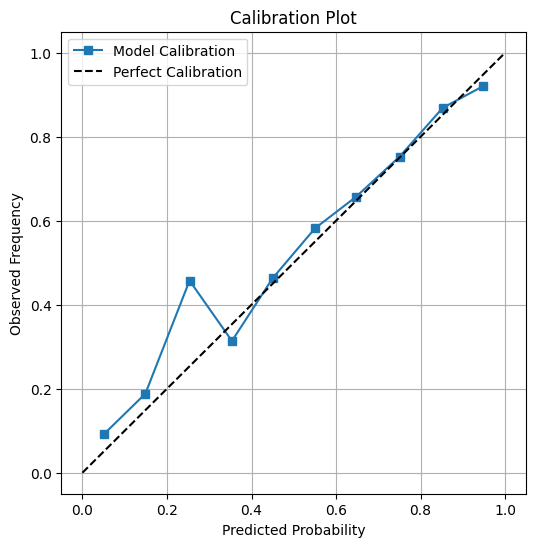

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

#simulated data: predicted probabilities and actual outcomes
np.random.seed(42)
predicted_probs = np.random.rand(1000)  #random probabilities between 0 and 1
actual_outcomes = (predicted_probs > np.random.rand(1000)).astype(int)  #simulated binary outcomes

#we introduce a perturbation in the simulated data, just to make things more interesting
mask = (predicted_probs > 0.25) & (predicted_probs < 0.30)
actual_outcomes[mask] = ((predicted_probs[mask]*2) > np.random.rand(sum(mask))).astype(int)  #simulated binary outcomes

#compute calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(actual_outcomes, predicted_probs, n_bins=10)

#plot calibration curve
plt.figure(figsize=(6, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model Calibration")
plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")  # Diagonal reference line
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Plot")
plt.legend()
plt.grid(True)
plt.show()

The example above shows an (exaggerated) trend in our predictor: all probabilities are correctly estimated (the dots are close to the perfect calibration line), with the only exception of the interval between 0.25 and 0.35. In this case further analysis would be required.

# Brier score (predicting probabilities)

Similarly to calibration curves, Brier score is used when the model is used to predict probabilities. It is a specialized metric. It is computed as:

```
               1     N
Brier Score = --- *  SUM (Pi - Oi)^2
               N     i=1
```

With:

* N : number of predictions
* Pi : predicted probability of event occurring for sample i
* Oi : actual outcome for sample i (1 if event occurred, 0 if it didn't)

It is interpreted as an error:

* Brier Score = 0 : perfect predictions
* Brier Score = 1 : worst possible predictions
* lower Brier Score: better predictions

Unlike classification accuracy, the Brier Score penalizes incorrect confidence levels. A model that predicts 90% probability but is wrong is penalized more than one that predicts 60% and is wrong.

Let's see a code example using [brier_score_loss function from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html).

In [23]:
from sklearn.metrics import brier_score_loss

#example: predicted probabilities and actual binary outcomes
#actual outcomes (1 = event occurred, 0 = event did not occur)
y_pred = [0.1, 0.4, 0.8, 0.6, 0.9]
y_true = [0,     0,   1,   1,   1]

#compute and print Brier Score
brier_score = brier_score_loss(y_true, y_pred)
print(f"Brier Score: {brier_score:.4f}")

Brier Score: 0.0760


# Normalized Discounted Cumulative Gain (predicting rankings)

Normalized Discounted Cumulative Gain (NDCG) is a ranking evaluation metric. It is used when the model predicts rankings, i.e. sorts the samples. This is widely use, for example, by search engines, whose task is to output the links to the websites starting from the ones most related to your query.
NDCG is also commonly used when evaluating recommender systems ("play this next...") It quantifies how well the predicted ranking of items aligns with the ideal ranking.

NDCG is based on Discounted Cumulative Gain (DCG), which rewards highly relevant items appearing earlier in the ranked list while penalizing relevant items appearing later.

NDCG ranges from zero (worst possible ranking) to one (perfect ranking). We'll compute it using [ndcg_score from sklearn library](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ndcg_score.html).


In [46]:
import numpy as np
from sklearn.metrics import ndcg_score

#example: relevance scores of retrieved documents. Higher values
#mean that the item has higher interest for the ranking
y_true = np.array([[  5,   2,   3,   0,   1,  4]])  #true relevance scores, 0 means top
y_pred = np.array([[  4, 1.0, 2.0, 3.0, 0.0, 1.5]])  #predicted ranking scores

#compute NDCG
ndcg = ndcg_score(y_true, y_pred)
print(f"NDCG Score: {ndcg:.4f}")

NDCG Score: 0.9105


Note that the actual values in the predictions don't count:

In [49]:
#doubling the predictions
y_new = y_pred * 2
ndcg = ndcg_score(y_true, y_new)
print(f"[doubled] NDCG Score : {ndcg:.4f}")

#introducing a bias
y_new = y_pred + 5
ndcg = ndcg_score(y_true, y_new)
print(f"[ biased] NDCG Score : {ndcg:.4f}")

#exaggerating the importance of the top-classified element
y_new = y_pred
y_new[0][0] = 100
ndcg = ndcg_score(y_true, y_new)
print(f"[megatop] NDCG Score : {ndcg:.4f}")

[doubled] NDCG Score : 0.9105
[ biased] NDCG Score : 0.9105
[megatop] NDCG Score : 0.9105


It is also possible to compute NDCG only on the top samples (e.g. only on the top three). In this case the predictions for lower scoring samples are just ignored. It is implemented as:

In [52]:
#ranking will focus on the top three predictions
#In this example we have perfect ranking of the top three
#samples and completely wrong ranking for the other three
y_true = np.array([[ 10,  9,  8,  7,  6,  5,  4,  3,  2,  1]])
y_pred = np.array([[ 10,  9,  8, -7, -6, -5, -4, -3, -2, -1]])

#compute NDCG on all samples (three good ranking, seven bad ranking)
ndcg = ndcg_score(y_true, y_pred)
print(f"[ all] NDCG Score : {ndcg:.4f}")

#compute NDCG only on the top three samples (perfect ranking)
ndcg = ndcg_score(y_true, y_pred, k=3)
print(f"[top3] NDCG Score : {ndcg:.4f}")

[ all] NDCG Score : 0.9575
[top3] NDCG Score : 1.0000
